# HOUSE PRICES
---

![title](Pictures/house_pic1.jpg)

---

## Dataset Description
---

The **House Price Dataset** contains data on residential homes sold in the Seattle area. It includes various features about the properties such as physical characteristics, geographic location, and sale details.  
The main objective is to **predict the house sale price** based on these features.

### List of attributes

- **id**: unique identifier for each property.
- **date**: date the house was sold.
- **price**: the sale price of the house (target variable).
- **bedrooms**: number of bedrooms.
- **bathrooms**: number of bathrooms (may include decimals for half baths).
- **sqft_living**: interior living space (in square feet).
- **sqft_lot**: size of the lot (in square feet).
- **floors**: number of floors in the house.
- **waterfront**: whether the house has a view to a waterfront (1 = yes, 0 = no).
- **view**: index indicating quality of view from the house (0–4).
- **condition**: condition of the house (1 = poor, 5 = excellent).
- **grade**: overall grade based on construction and design (1–13).
- **sqft_above**: square footage of the house apart from basement.
- **sqft_basement**: square footage of the basement.
- **yr_built**: year the house was built.
- **yr_renovated**: year the house was renovated (0 if never renovated).
- **zipcode**: ZIP code of the house location.
- **lat**: latitude coordinate.
- **long**: longitude coordinate.
- **sqft_living15**: living space area of nearby 15 houses.
- **sqft_lot15**: lot area of nearby 15 houses.

The goal is to explore how different features (e.g., location, size, age, view) affect house prices and to build predictive models for estimating house values.

---

### Research questions:
1. **Can house prices be predicted accuratly using only one or two key features?**  

2. **Which features have the highest impact on the predicted sale price?**  

3. **How does the condition or quality of a house affect its market value?**  


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime
from matplotlib import colormaps # colormap
import seaborn as sns
import warnings
import statsmodels.formula.api as smf

# for spliting the data
from sklearn.model_selection import train_test_split

# for model evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import DecisionBoundaryDisplay

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df_raw = pd.read_csv('house_price_seattle.csv')
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
pd.set_option('display.float_format', '{:.0f}'.format)
df_raw.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
mean,4580301521,540088,3,2,2080,15107,1,0,0,3,8,1788,292,1971,84,98078,48,-122,1987,12768
std,2876565571,367127,1,1,918,41421,1,0,1,1,1,828,443,29,402,54,0,0,685,27304
min,1000102,75000,0,0,290,520,1,0,0,1,1,290,0,1900,0,98001,47,-123,399,651
25%,2123049194,321950,3,2,1427,5040,1,0,0,3,7,1190,0,1951,0,98033,47,-122,1490,5100
50%,3904930410,450000,3,2,1910,7618,2,0,0,3,7,1560,0,1975,0,98065,48,-122,1840,7620
75%,7308900445,645000,4,2,2550,10688,2,0,0,4,8,2210,560,1997,0,98118,48,-122,2360,10083
max,9900000190,7700000,33,8,13540,1651359,4,1,4,5,13,9410,4820,2015,2015,98199,48,-121,6210,871200


### Data preprocessing
---

In [8]:
# Removing columns I'm not interested in
df = df_raw.drop(columns =['id', 'zipcode', 'lat', 'long'])

# Extracting from the 'date' column the year and the month, and saving in a new column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Creating a binary column rapresenting if the house has been renovated
flag = []  #new list for saving the binary values

for value in df['yr_renovated']:
    if value != 0:
        flag.append(1)
    else:
        flag.append(0)

df['renovated_flg'] = flag

# Conversion factor from ft^2 to m^2
conversion_factor = 0.092903

# Find all columns with 'sqft' in it 
sqft_columns = [col for col in df.columns if 'sqft' in col]

# Apply the conversion
df[sqft_columns] = df[sqft_columns] * conversion_factor

# Rename the columns
df.rename(columns={col: col.replace('sqft', 'sqm') for col in sqft_columns}, inplace=True)


In [9]:
# Split data into train and test sets
train, test = train_test_split(df, test_size=0.3, random_state=1)

In [10]:
df.head()

,date,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_above,sqm_basement,yr_built,yr_renovated,sqm_living15,sqm_lot15,year,month,renovated_flg
0,2014-10-13,221900,3,1,110,525,1,0,0,3,7,110,0,1955,0,124,525,2014,10,0
1,2014-12-09,538000,3,2,239,673,2,0,0,3,7,202,37,1951,1991,157,710,2014,12,1
2,2015-02-25,180000,2,1,72,929,1,0,0,3,6,72,0,1933,0,253,749,2015,2,0
3,2014-12-09,604000,4,3,182,465,1,0,0,5,7,98,85,1965,0,126,465,2014,12,0
4,2015-02-18,510000,3,2,156,751,1,0,0,3,8,156,0,1987,0,167,697,2015,2,0


In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,21613,2014-10-29 04:38:01.959931648,2014-05-02 00:00:00,2014-07-22 00:00:00,2014-10-16 00:00:00,2015-02-17 00:00:00,2015-05-27 00:00:00,NaN
price,21613,540088,75000,321950,450000,645000,7700000,367127
bedrooms,21613,3,0,3,3,4,33,1
bathrooms,21613,2,0,2,2,2,8,1
sqm_living,21613,193,27,133,177,237,1258,85
sqm_lot,21613,1403,48,468,708,993,153416,3848
floors,21613,1,1,1,2,2,4,1
waterfront,21613,0,0,0,0,0,1,0
view,21613,0,0,0,0,0,4,1
condition,21613,3,1,3,3,4,5,1


## Data Visualization
---

### Histograms
---

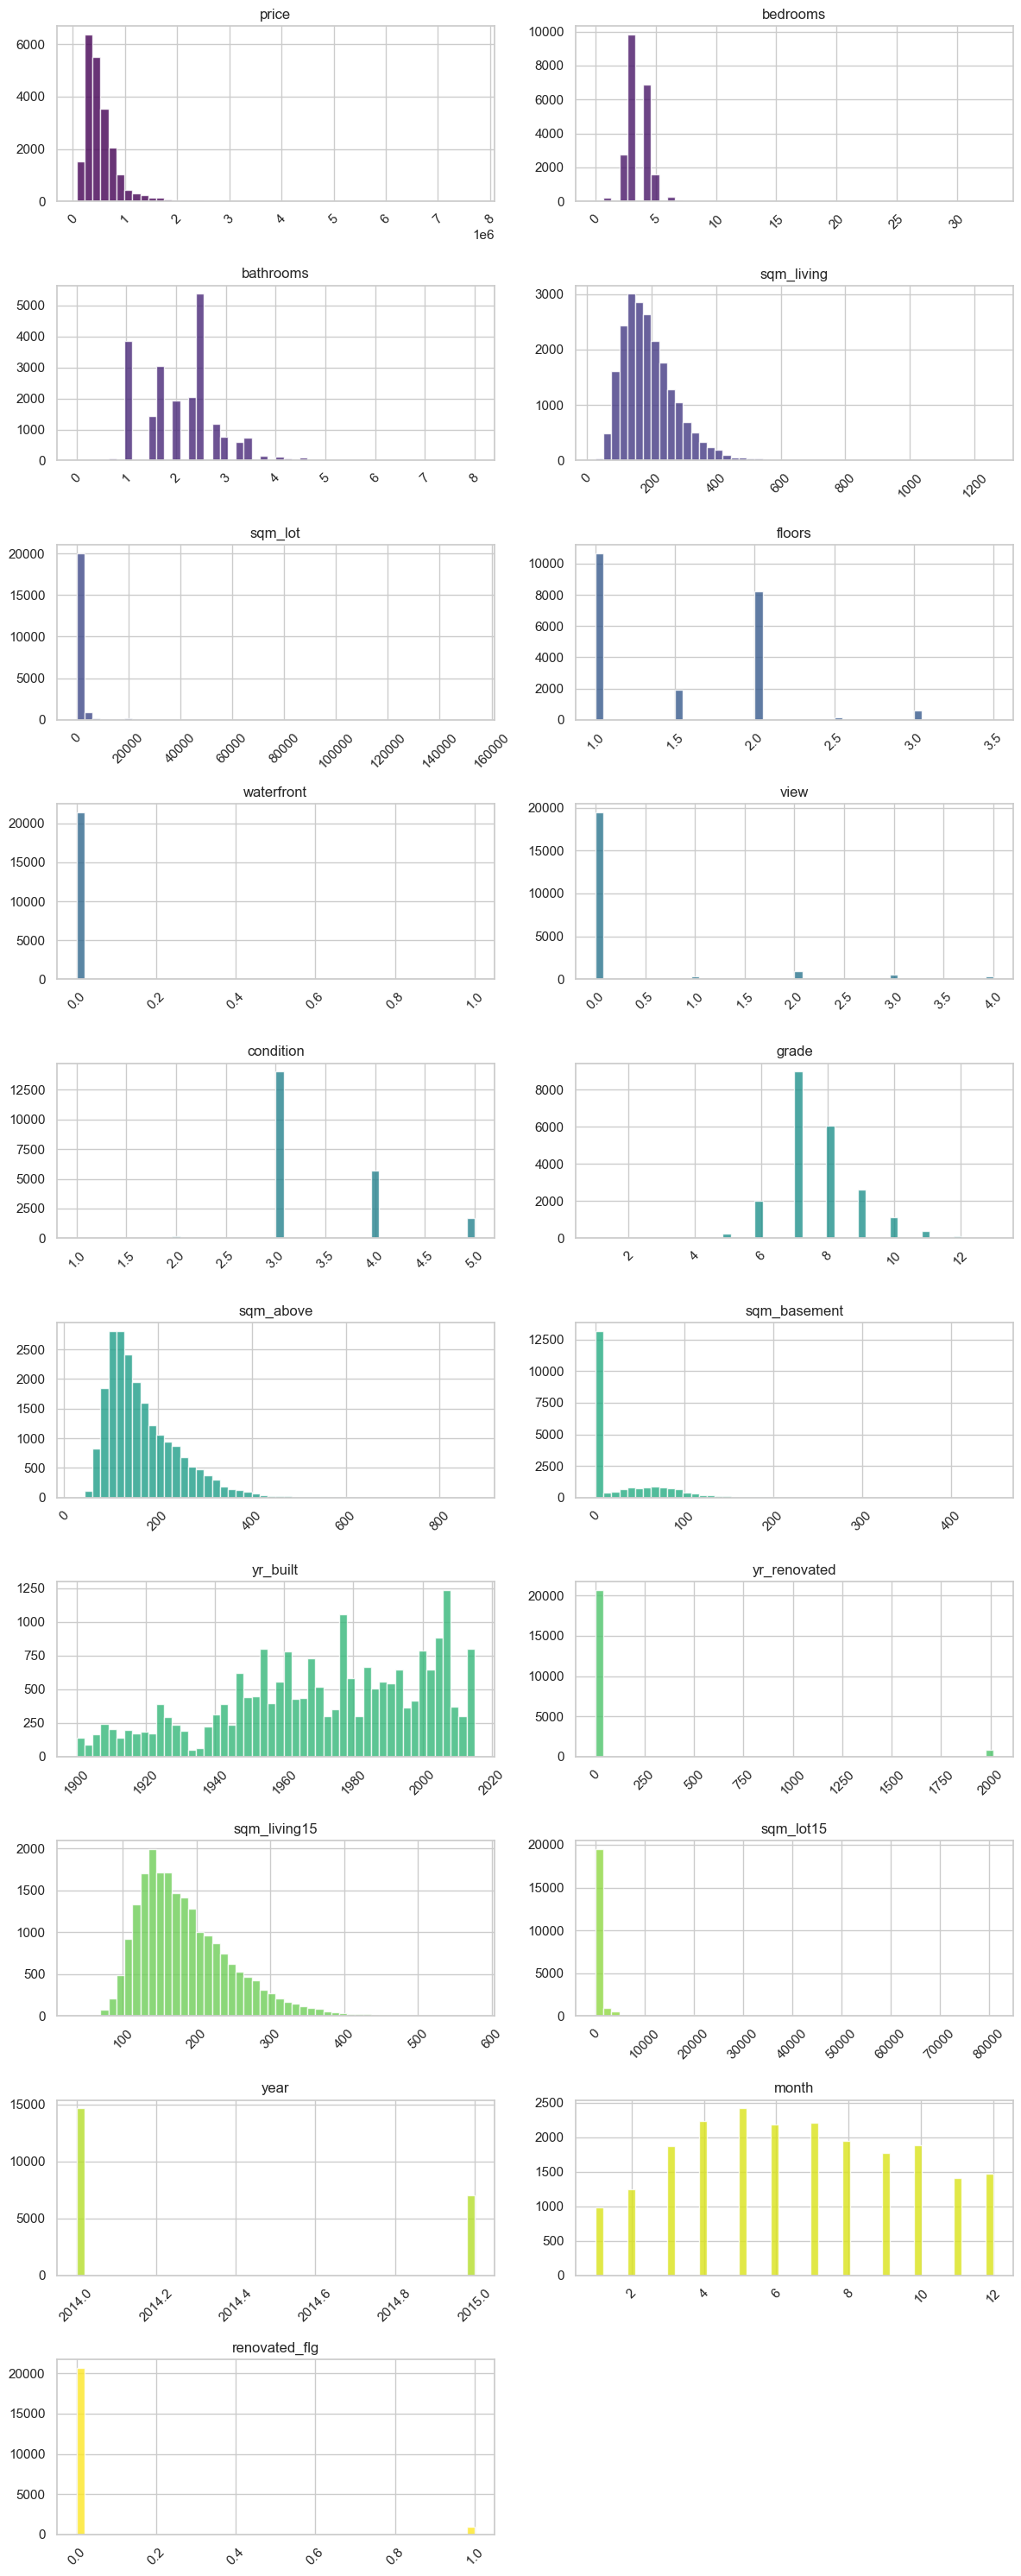

In [14]:
sns.set(style="whitegrid", font_scale=1)

num_list = list(df.columns[1:])

fig = plt.figure(figsize=(12,30))

# Colormap
color = colormaps['viridis'].resampled(len(num_list))  # 'plasma', 'cool', 'rainbow'
color_list = color(np.linspace(0, 1, len(num_list)))

for i in range(len(num_list)):
    plt.subplot(10,2,i+1)
    plt.title(num_list[i])
    plt.xticks(rotation=45)
    plt.hist(df[num_list[i]],bins=50, color=color_list[i],edgecolor='white',alpha=0.8)

plt.tight_layout()

### Boxplot
---

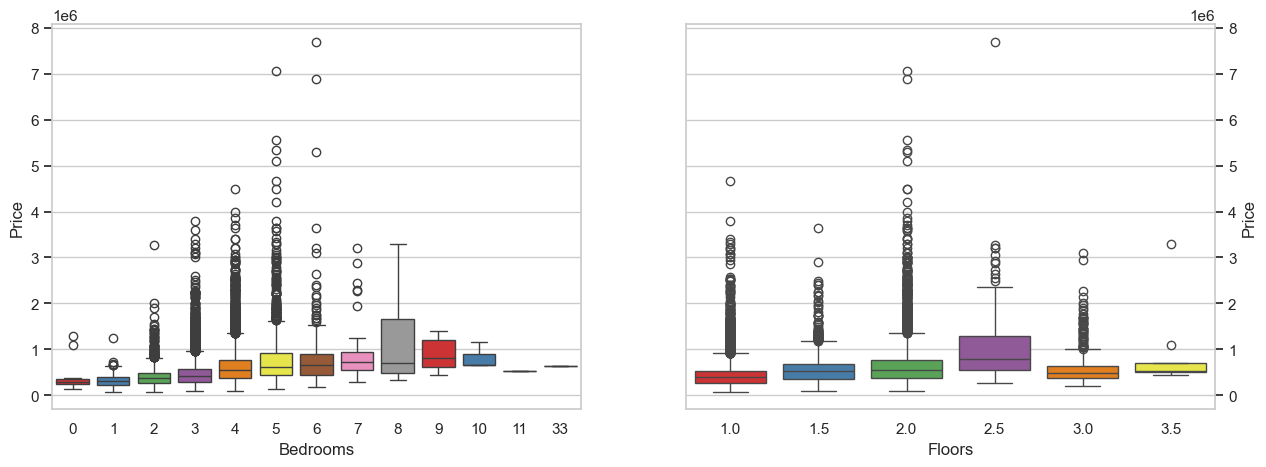

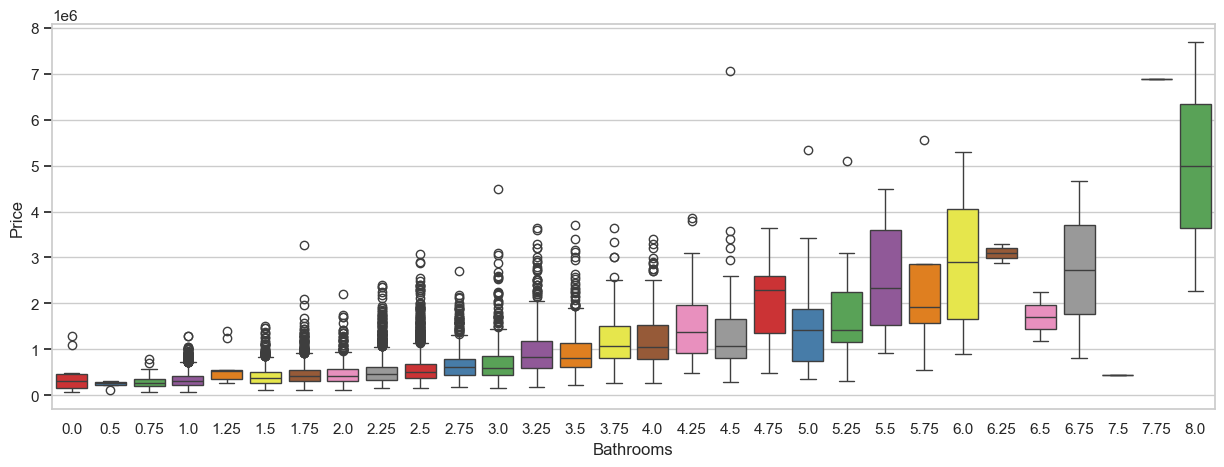

In [16]:
fig, axis = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axis[0], palette='Set1')
sns.boxplot(x=df['floors'],y=df['price'], ax=axis[1],  palette='Set1')
axis[0].set(xlabel='Bedrooms', ylabel='Price')
axis[0].yaxis.tick_left()
axis[1].yaxis.set_label_position("right")
axis[1].yaxis.tick_right()
axis[1].set(xlabel='Floors', ylabel='Price')

fig, axis = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axis, palette='Set1');
axis.yaxis.tick_left()
axis.set(xlabel='Bathrooms', ylabel='Price');

### Scatter plot matrix
---

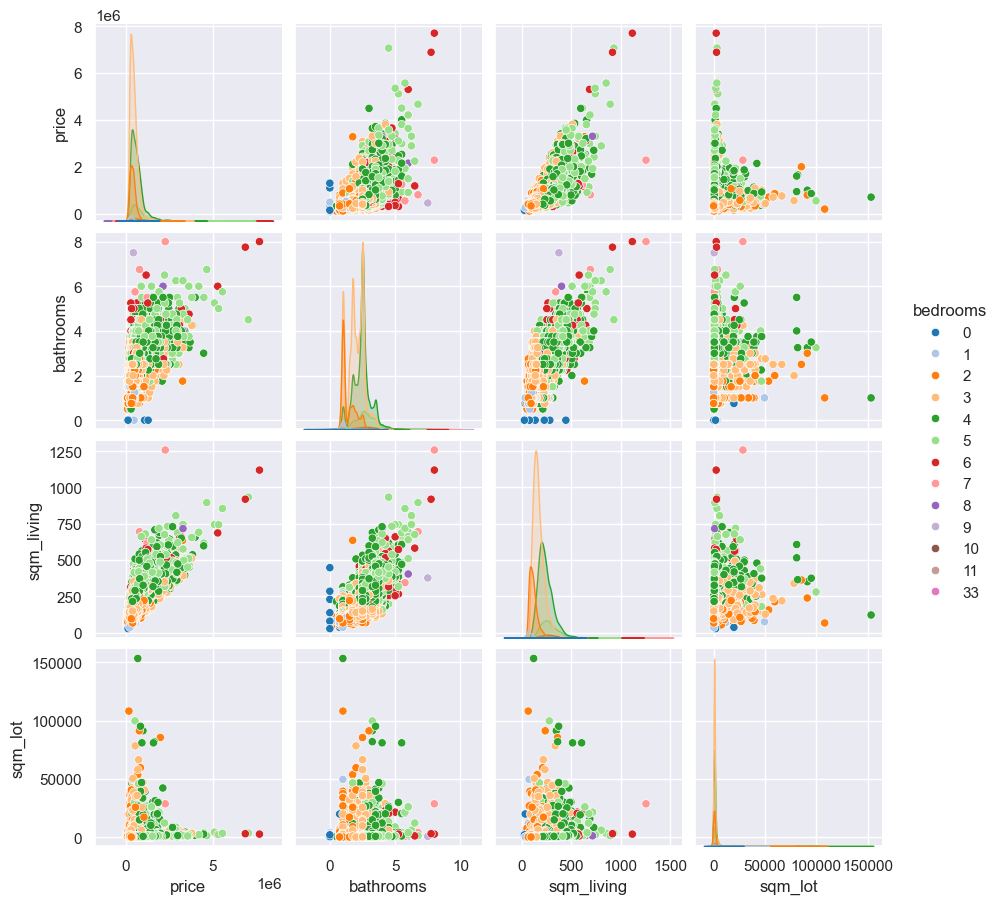

In [18]:
sns.set_style("darkgrid")
#df_red = df.drop(['date', 'floors', 'waterfront', 'yr_built', 'yr_renovated', 'renovated_flg', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'year', 'month', 'condition', 'view', 'grade'], axis = 1)
df_red = df.drop(['date', 'floors', 'waterfront', 'yr_built', 'yr_renovated', 'renovated_flg', 'sqm_living15', 'sqm_lot15', 'sqm_above', 'sqm_basement', 'year', 'month', 'condition', 'view', 'grade'], axis = 1)

sns.pairplot(df_red, hue='bedrooms', palette='tab20', height = 2.3);

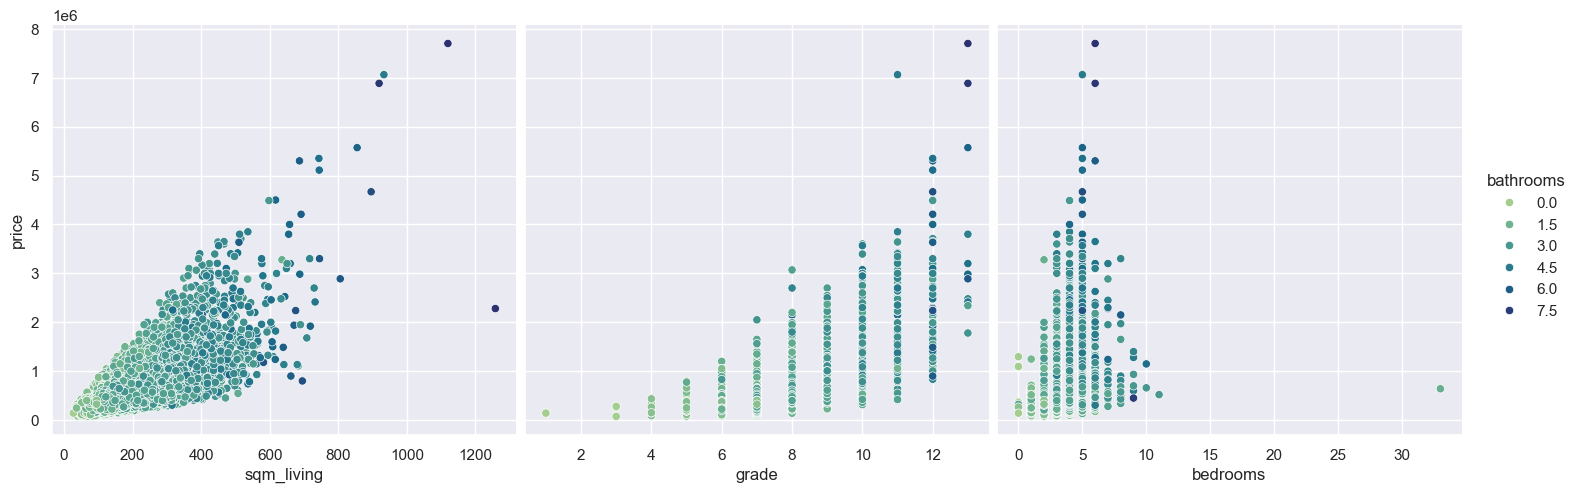

In [19]:
sns.set_style("darkgrid")
sns.pairplot(df, x_vars=['sqm_living', 'grade', 'bedrooms'], y_vars=['price'], hue = 'bathrooms', palette = 'crest',  height = 5);

### Correlation Matrix
---

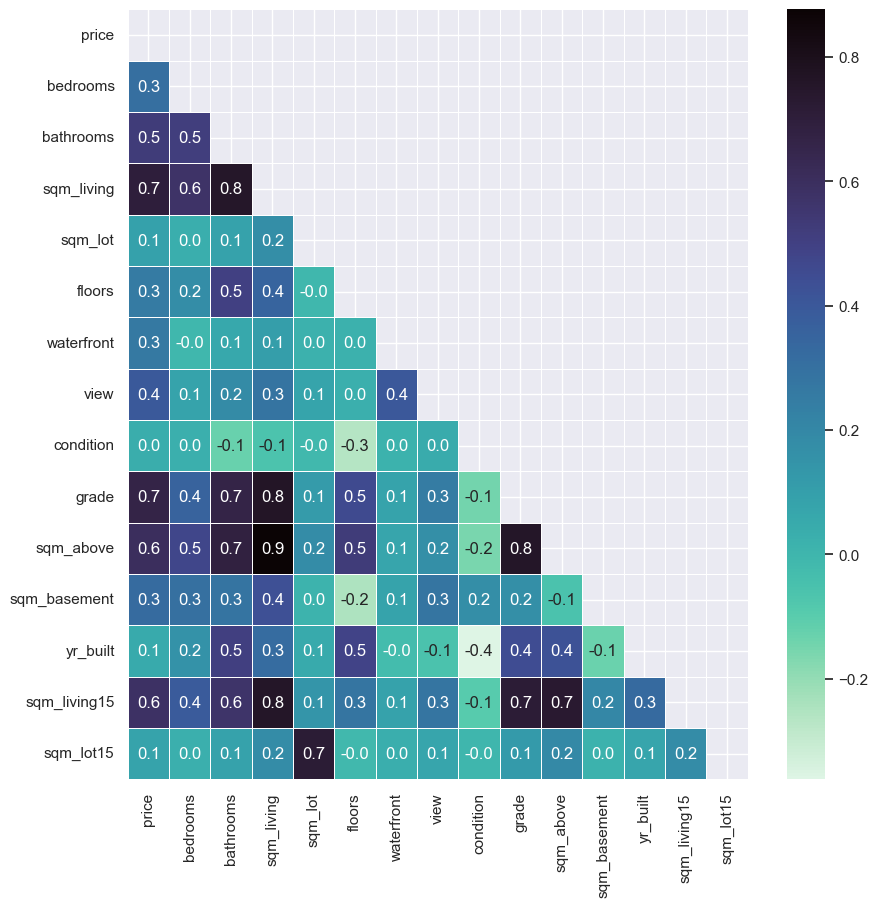

In [21]:
df_corr = df.drop(['year', 'month', 'date', 'renovated_flg','yr_renovated'], axis = 1) 

corr_matrix = df_corr.corr()

# Getting the Upper Triangle of the correlation matrix
corner = np.triu(corr_matrix)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, mask = corner, annot=True, fmt=".1f", linewidth=.5, cmap= 'mako_r')
plt.show()


## Simple Linear Regression: price ~ sqm_living
---

### Model 
---

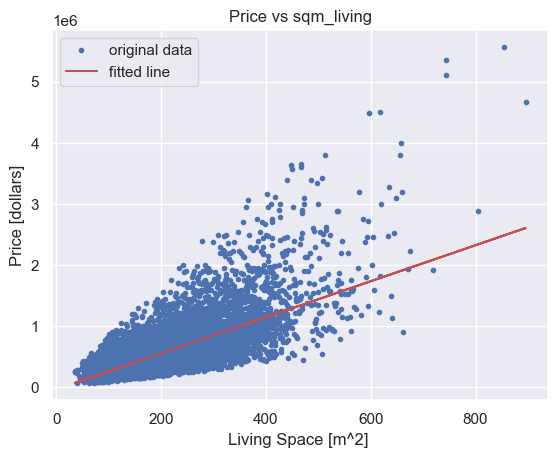

In [24]:
# Estimate the model
res1 = smf.ols('price ~ sqm_living', data = train).fit()

# Compute estimated output for values in train data set

# plot the true vs predicted values
x = train['sqm_living']
y = train['price']

res1_intercept = res1.params.Intercept
res1_slope =  res1.params.sqm_living

plt.figure()

plt.plot(x, y, '.', label='original data');  # Original 
plt.plot(x, res1_intercept + res1_slope * x, 'r', label = 'fitted line'); # Predicted 

plt.legend()
plt.xlabel('Living Space [m^2] ')
plt.ylabel('Price [dollars]')
plt.title('Price vs sqm_living');


### Summary
---

In [26]:
# Print results of estimated model
res1 .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 1.435e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:37:32   Log-Likelihood:            -2.0974e+05
No. Observations:               15129   AIC:                         4.195e+05
Df Residuals:                   15127   BIC:                         4.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.136e+04   5179.339     -6.054      0.000   -4.15e+04   -2.12e+04
sqm_living  2947.2503     24.602    119.797      0.000    2899.027    2995.473
==============================================================================
Omnibus:                     8846.338   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174097.413
Skew:                           2.424   Prob(JB):                         0.00
Kurtosis:                      18.896   Cond. No.                         528.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual PLot
---

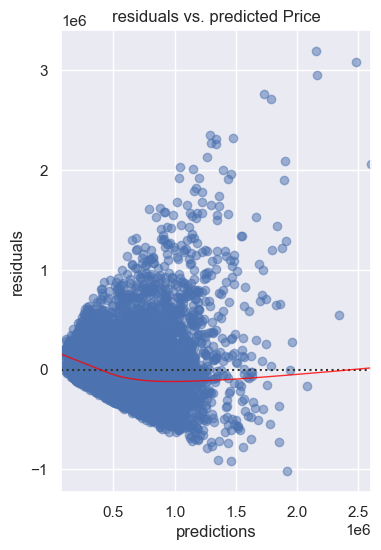

In [28]:
# Prediction
yhat = res1.fittedvalues

# Residuals
resid = res1.resid

# Residual plot
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot()

# lowess = to show the moving avarege of the residual in order to show trend
sns.residplot(x=yhat, y=resid, lowess=True, scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax);
ax.set_xlabel('predictions')
ax.set_ylabel('residuals')
ax.set_title('residuals vs. predicted Price');

The simple linear model using only `sqm_living` explains about 49% of the variance in house prices ( $R^2$ = 0.487 ). However, residual patterns suggest non-linearity and heteroscedasticity.
To improve model performance, we introduce an additional predictor: `grade`.

## Multiple Linear Regression: price ~ sqm_living + grade
---

### Model and Summary
---

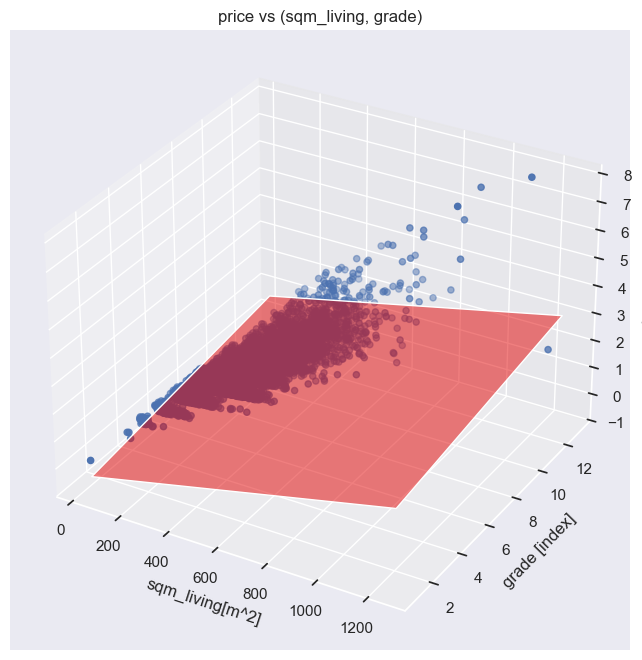

In [32]:
# Estimate the model
res2 = smf.ols('price ~ sqm_living + grade', data = train).fit()

# Make a plot
intercept = res2.params.Intercept
slope_sqm_living = res2.params.sqm_living
slope_grade = res2.params.grade

d1 = [df['sqm_living'].min(), df['sqm_living'].max()]
d2 = [df['grade'].min(), df['grade'].max()]

# Coordinates of four points
xx, yy = np.meshgrid(d1, d2)
zz = intercept + slope_sqm_living* xx + slope_grade*yy

# Create the figure
fig = plt.figure(figsize = (8, 10))

# Add an axes
ax = fig.add_subplot(projection='3d')

# Plot the plane
ax.plot_surface(xx, yy, zz, color='red', alpha=0.5)

# Plot the data set
ax.scatter(df['sqm_living'],df['grade'],df['price'])

ax.set_xlabel('sqm_living[m^2]')
ax.set_ylabel('grade [index]')
ax.set_zlabel('price [k-units]')
ax.set_title('price vs (sqm_living, grade)');


In [33]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     8582.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:37:34   Log-Likelihood:            -2.0905e+05
No. Observations:               15129   AIC:                         4.181e+05
Df Residuals:                   15126   BIC:                         4.181e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -5.87e+05   1.54e+04    -38.025      0.000   -6.17e+05   -5.57e+05
sqm_living  1899.0153     36.243     52.397      0.000    1827.975    1970.055
grade       9.896e+04   2604.164     37.999      0.000    9.39e+04    1.04e+05
==============================================================================
Omnibus:                     9851.211   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           259767.996
Skew:                           2.720   Prob(JB):                         0.00
Kurtosis:                      22.557   Cond. No.                     1.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual Plot
---

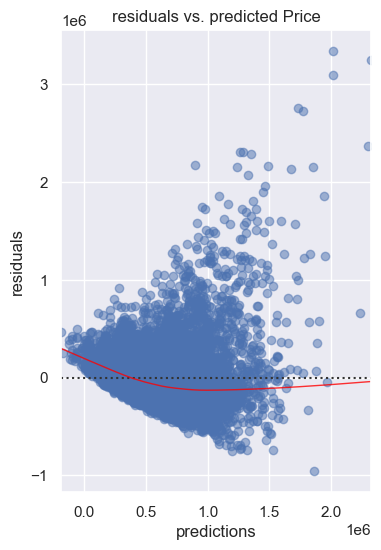

In [35]:
# Prediction
yhat = res2.fittedvalues

# Residuals
resid = res2.resid

# Residual plot
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot()

# lowess = to show the moving avarege of the residual in order to show trend
sns.residplot(x=yhat, y=resid, lowess=True, scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax);
ax.set_xlabel('predictions')
ax.set_ylabel('residuals')
ax.set_title('residuals vs. predicted Price');

Adding `grade` as a second predictor slightly improves the model ( $R^2$ = 0.532 ). However, the residual plot still shows a cone-shaped pattern, suggesting heteroscedasticity. For this reason, we next apply a log transformation to the output variable.

## Multiple Regression: np.log(price) ~ sqm_living + grade
---

### Model
---

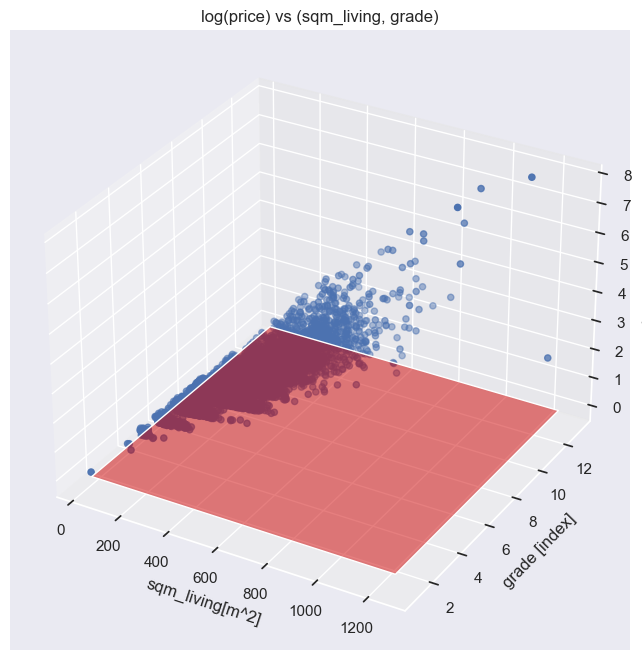

In [39]:
# MLR: estimate the model 
res3 = smf.ols('np.log(price) ~ sqm_living + grade', data=train).fit()

# Make a plot
intercept = res3.params.Intercept
slope_sqm_living = res3.params.sqm_living
slope_grade = res3.params.grade

d1 = [df['sqm_living'].min(), df['sqm_living'].max()]
d2 = [df['grade'].min(), df['grade'].max()]

# Coordinates of four points
xx, yy = np.meshgrid(d1, d2)
zz = intercept + slope_sqm_living* xx + slope_grade*yy

# Create the figure
fig = plt.figure(figsize = (8, 10))

# Add an axes
ax = fig.add_subplot(projection='3d')

# Plot the plane
ax.plot_surface(xx, yy, zz, color='red', alpha=0.5)

# Plot the data set
ax.scatter(df['sqm_living'],df['grade'],df['price'])

ax.set_xlabel('sqm_living[m^2]')
ax.set_ylabel('grade [index]')
ax.set_zlabel('price [k-units]')
ax.set_title('log(price) vs (sqm_living, grade)');


### Summary
---

In [41]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     9231.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:37:38   Log-Likelihood:                -5657.9
No. Observations:               15129   AIC:                         1.132e+04
Df Residuals:                   15126   BIC:                         1.134e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1846      0.022    499.740      0.000      11.141      11.229
sqm_living     0.0024   5.25e-05     45.499      0.000       0.002       0.002
grade          0.1828      0.004     48.407      0.000       0.175       0.190
==============================================================================
Omnibus:                       42.113   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.197
Skew:                           0.112   Prob(JB):                     1.13e-09
Kurtosis:                       2.878   Cond. No.                     1.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual Plot
---

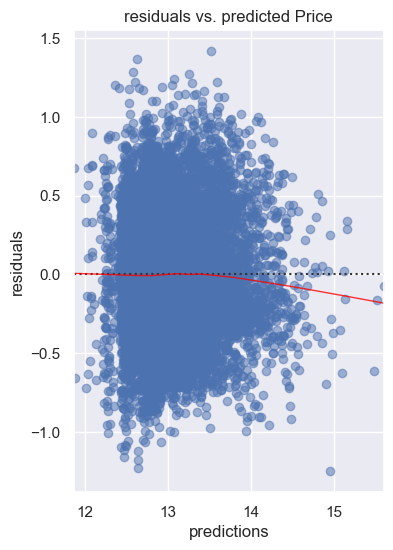

In [43]:
# Prediction
yhat = res3.fittedvalues

# Residuals
resid = res3.resid

# Residual plot
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot()

# lowess = to show the moving avarege of the residual in order to show trend
sns.residplot(x=yhat, y=resid, lowess=True, scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax);
ax.set_xlabel('predictions')
ax.set_ylabel('residuals')
ax.set_title('residuals vs. predicted Price');

After the introduction of the log transformation, no evident trend can be seen from the residual plot, while the performance of the model doesn't change significantly since $R^2$ is almost the same.

---


## Multiple Regression: Full Model
---


### Model and Summary
---

In [47]:
# MLR: estimate the model 
res_full = smf.ols('np.log(price) ~ sqm_living + sqm_lot + floors+ waterfront + view + condition + sqm_above + yr_built + grade + bedrooms + sqm_living15', data=train).fit()
res_full.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     2494.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:37:40   Log-Likelihood:                -3863.8
No. Observations:               15129   AIC:                             7752.
Df Residuals:                   15117   BIC:                             7843.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.6529      0.213     96.925      0.000      20.235      21.071
sqm_living       0.0025   7.89e-05     32.058      0.000       0.002       0.003
sqm_lot      -1.135e-07   6.49e-07     -0.175      0.861   -1.39e-06    1.16e-06
floors           0.1511      0.006     24.083      0.000       0.139       0.163
waterfront       0.3829      0.032     11.976      0.000       0.320       0.446
view             0.0368      0.004      9.379      0.000       0.029       0.045
condition        0.0427      0.004     10.031      0.000       0.034       0.051
sqm_above       -0.0011   8.38e-05    -13.280      0.000      -0.001      -0.001
yr_built        -0.0051      0.000    -46.622      0.000      -0.005      -0.005
grade            0.2107      0.004     54.282      0.000       0.203       0.218
bedrooms        -0.0100      0.003     -2.960      0.003      -0.017      -0.003
sqm_living15     0.0011   6.71e-05     16.523      0.000       0.001       0.001
==============================================================================
Omnibus:                       44.551   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.540
Skew:                          -0.112   Prob(JB):                     7.83e-11
Kurtosis:                       3.155   Cond. No.                     3.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual PLot
---

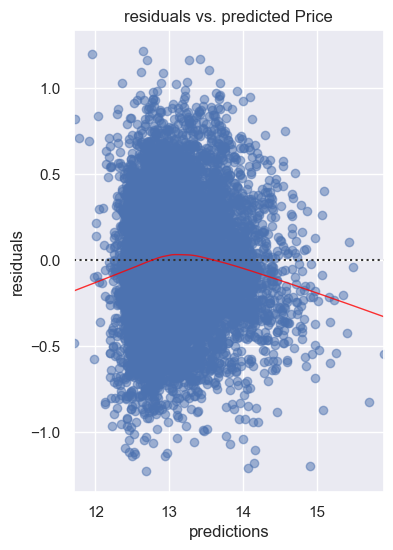

In [49]:
# Prediction
yhat = res_full.fittedvalues

# Residuals
resid = res_full.resid

# Residual plot
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot()

# lowess = to show the moving avarege of the residual in order to show trend
sns.residplot(x=yhat, y=resid, lowess=True, scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax);
ax.set_xlabel('predictions')
ax.set_ylabel('residuals')
ax.set_title('residuals vs. predicted Price');

When all the predictors are used in the model we notice a significant increase in $R^2$=0.645, indicating an improvement of the performance of the model, but we also notice that the p-value of `sqm_lot` is greater than 0.05,  indicating it is not statistically significant. For this reason we'll remove `sqm_lot`.

We can also notiice a curved trend from the residual plot, suggesting non-linearity that is not captured by the current model. So we'll try to include a quadratic term for `sqm_living`.

## Full Model with log transformation + quadratic term
---

### Model and Summary
---

In [53]:
# MLR: estimate the model 
#res_full1 = smf.ols('price~ sqm_living + np.power(sqm_living , 2) + floors+ waterfront + view + condition + sqm_above + yr_built + grade + bedrooms + sqm_living15', data=train).fit()
res_full1 = smf.ols('np.log(price)~ sqm_living + np.power(sqm_living , 2) + floors+ waterfront + view + condition + sqm_above + yr_built + grade + bedrooms + sqm_living15', data=train).fit()
res_full1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2514.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:37:58   Log-Likelihood:                -3826.0
No. Observations:               15129   AIC:                             7676.
Df Residuals:                   15117   BIC:                             7768.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  20.7879      0.213     97.570      0.000      20.370      21.206
sqm_living                  0.0035      0.000     25.804      0.000       0.003       0.004
np.power(sqm_living, 2) -1.784e-06   2.05e-07     -8.694      0.000   -2.19e-06   -1.38e-06
floors                      0.1456      0.006     23.287      0.000       0.133       0.158
waterfront                  0.3927      0.032     12.307      0.000       0.330       0.455
view                        0.0382      0.004      9.761      0.000       0.031       0.046
condition                   0.0402      0.004      9.458      0.000       0.032       0.049
sqm_above                  -0.0010   8.34e-05    -12.572      0.000      -0.001      -0.001
yr_built                   -0.0052      0.000    -47.401      0.000      -0.005      -0.005
grade                       0.2104      0.004     54.388      0.000       0.203       0.218
bedrooms                   -0.0177      0.003     -5.089      0.000      -0.025      -0.011
sqm_living15                0.0010   6.79e-05     14.940      0.000       0.001       0.001
==============================================================================
Omnibus:                       36.612   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.507
Skew:                          -0.097   Prob(JB):                     4.35e-09
Kurtosis:                       3.154   Cond. No.                     5.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual Plot
----

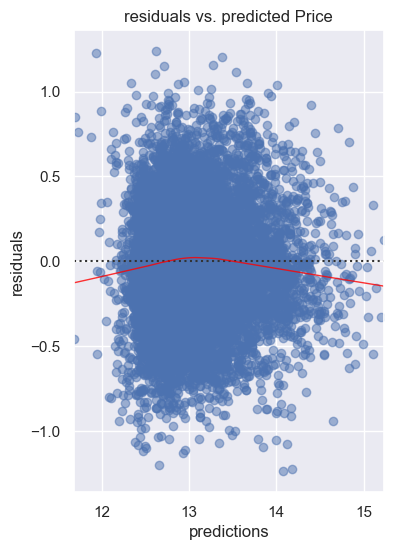

In [55]:
# Prediction
yhat = res_full1.fittedvalues

# Residuals
resid = res_full1.resid

# Residual plot
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot()

# lowess = to show the moving avarege of the residual in order to show trend
sns.residplot(x=yhat, y=resid, lowess=True, scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax);
ax.set_xlabel('predictions')
ax.set_ylabel('residuals')
ax.set_title('residuals vs. predicted Price');

Introducing a quadratic term for `sqm_living` doesn't affect significantly the model performance ($R^2$= 0.647) but helps better capture the non-linear relationship between living space and price. All predictors are statistically significant, including the quadratic term, and the residual plot shows a reduced trend compared to the previous model.


## Final model selection and comparison
---

In [58]:
# compute the prediction
ypred1 = res1.predict(test)
ypred2 = res2.predict(test)
ypred3 = np.exp(res3.predict(test))
ypred4 = np.exp(res_full.predict(test))
ypred5 = np.exp(res_full1.predict(test))


r1 = r2_score(test['price'], ypred1)
print(f" R² on test data for res1: {r1:.3f}")
r2 = r2_score(test['price'], ypred2)
print(f" R² on test data for res2: {r2:.3f}")
r3 = r2_score(test['price'], ypred3)
print(f" R² on test data for res3: {r3:.3f}")
r4 = r2_score(test['price'], ypred4)
print(f" R² on test data for res_full: {r4:.3f}")
r5 = r2_score(test['price'], ypred5)
print(f" R² on test data for res_full1: {r5:.3f}")

 R² on test data for res1: 0.503
 R² on test data for res2: 0.539
 R² on test data for res3: 0.506
 R² on test data for res_full: 0.544
 R² on test data for res_full1: 0.696


After training five regression models of increasing complexity, we compared their performance on the test set using the $R^2$ score. 
For models trained on the log-transformed response (`res3`, `res_full`, and `res_full1`), the predictions are exponentiated using `np.exp()` to bring them back to the original price scale before computing the $R^2$ score.

The models considered were:

- **res1**: simple linear regression using `sqm_living` as the only predictor.
- **res2**: multivariate linear regression on `price` with two predictors: `sqm_living` and `grade`.
- **res3**: multivariate regression on log-transformed `price` with the same predictors as `res2`.
- **res_full**: full multivariate model on log-transformed `price`, using all predictors available.
- **res_full1**: full multivariate model on log-transformed `price`, after the removal of `sqm_lot` and including a quadratic term on `sqm_living`.

Among all models, **res_full1** is the most complex but it achieves the highest $R^2$ score on the test set. Although the increase in predictive performance compared to **res_full** (from 0.544 to 0.696) is notable, it is also important to notice that all coefficients in **res_full1** are statistically significant, and the residual plots show no evident trend.

For this reason, **res_full1** is selected as the final model, as it provides the best trade-off between complexity and predictive performance.

$$
\begin{aligned}
\widehat{\log(\text{price})} =\ & 20.7879 \\
&+ 0.0035 \cdot \text{sqm\_living} \\
&- 1.784 \cdot 10^{-6} \cdot (\text{sqm\_living})^2 \\
&+ 0.1456 \cdot \text{floors} \\
&+ 0.3927 \cdot \text{waterfront} \\
&+ 0.2902 \cdot \text{view} \\
&+ 0.0402 \cdot \text{condition} \\
&- 0.0010 \cdot \text{sqm\_above} \\
&+ 0.0020 \cdot \text{yr\_built} \\
&+ 0.2167 \cdot \text{grade} \\
&- 0.0035 \cdot \text{bedrooms} \\
&+ 0.0006 \cdot \text{sqm\_living15}
\end{aligned}
$$

where $\widehat{\log(\text{price})}$ is the predicted log-price of a house,  
and the predictors are defined as follows:

- `sqm_living`: interior living space in square meters  
- `floors`: number of floors  
- `waterfront`: binary variable indicating if the house has a waterfront view  
- `view`: index of the quality of the view  
- `condition`: condition of the house  
- `sqm_above`: square meters above ground  
- `yr_built`: year the house was built  
- `grade`: quality grade of the house  
- `bedrooms`: number of bedrooms  
- `sqm_living15`: average living space of the 15 nearest neighbors

Around 70% of the variability in 'price' is explained by the regression model when applied to new fresh data.